In [3]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# File paths
files = {
    1993: '/content/drive/MyDrive/BRFSS_DATA/1993BRFFS.XPT',
    1999: '/content/drive/MyDrive/BRFSS_DATA/1999BRFFS.XPT',
    2003: '/content/drive/MyDrive/BRFSS_DATA/2003BRFFS.xpt',
    2009: '/content/drive/MyDrive/BRFSS_DATA/2009BRFFS.XPT',
    2013: '/content/drive/MyDrive/BRFSS_DATA/2013BRFFS.XPT',
    2019: '/content/drive/MyDrive/BRFSS_DATA/2019BRFFS.XPT',
    2023: '/content/drive/MyDrive/BRFSS_DATA/BRFSS2023.XPT'
}

cols_to_keep = ['_AGEG5YR', '_INCOMG', '_RACEGR3', '_EDUCAG', '_HLTHPL1', 'MENTHLTH', '_RFHLTH', 'GENHLTH']
dfs = []
for year, path in files.items():
    df = pd.read_sas(path, format='xport')
    df = df[[col for col in cols_to_keep if col in df.columns]]  # Keep only necessary columns
    df['Year'] = year
    dfs.append(df)


df_all = pd.concat(dfs, ignore_index=True)
print(df_all.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2302907, 9)


In [5]:
import pandas as pd

# Map income codes to labels
income_map = {1: 'Low', 2: 'Low', 3: 'Low', 4: 'Medium', 5: 'Medium', 6: 'High'}
if '_INCOMG' in df_all.columns:
    df_all['Income Level'] = df_all['_INCOMG'].map(income_map)

# Map age group codes to labels
age_map = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44',
    6: '45-49', 7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69',
    11: '70-74', 12: '75-79', 13: '80+'
}
if '_AGEG5YR' in df_all.columns:
    df_all['Age Group'] = df_all['_AGEG5YR'].map(age_map)

# Filter rows with non-null mental health data
df_mental = df_all[['Age Group', 'Income Level', 'MENTHLTH']].dropna()

# Group by age and income → calculate mean mental health days
mental_health_table = df_mental.groupby(['Age Group', 'Income Level'])['MENTHLTH'].mean().reset_index()
mental_health_table.rename(columns={'MENTHLTH': 'Avg. Poor Mental Health Days'}, inplace=True)

# Display
print(mental_health_table)

# Optional export
# mental_health_table.to_csv('/content/mental_health_summary.csv', index=False)


   Age Group Income Level  Avg. Poor Mental Health Days
0      18-24          Low                     49.304280
1      18-24       Medium                     48.497041
2      25-29          Low                     52.570179
3      25-29       Medium                     54.451887
4      30-34          Low                     53.470025
5      30-34       Medium                     56.571328
6      35-39          Low                     53.759368
7      35-39       Medium                     58.127785
8      40-44          Low                     53.163978
9      40-44       Medium                     59.705552
10     45-49          Low                     52.738775
11     45-49       Medium                     61.633598
12     50-54          Low                     53.522035
13     50-54       Medium                     63.640029
14     55-59          Low                     55.224162
15     55-59       Medium                     65.891659
16     60-64          Low                     60

Filtered data rows: 748156
  Income Level         Race   Count   Total    Percent
0          Low        AI/AN    7124  292539   2.435231
1          Low        Asian   16265  292539   5.559942
2          Low        Black   33559  292539  11.471633
3          Low  Other/Multi   39340  292539  13.447780
4          Low        White  196251  292539  67.085414
5       Medium        AI/AN    7834  455617   1.719427
6       Medium        Asian   19274  455617   4.230307
7       Medium        Black   24975  455617   5.481578
8       Medium  Other/Multi   22390  455617   4.914215
9       Medium        White  381144  455617  83.654473


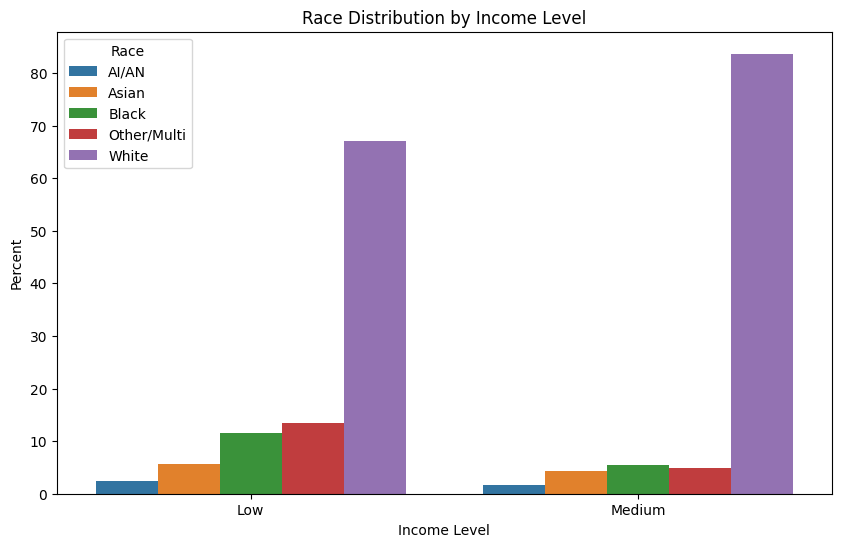

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Map race codes to labels
race_map = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'AI/AN', 5: 'Other/Multi'}
if '_RACEGR3' in df_all.columns:
    df_all['Race'] = df_all['_RACEGR3'].map(race_map)
elif '_RACEGR4' in df_all.columns:
    df_all['Race'] = df_all['_RACEGR4'].map(race_map)

# ✅ Filter valid income and race
valid_income = ['Low', 'Medium']
valid_race_codes = [1, 2, 3, 4, 5]

df_filtered = df_all[
    df_all['Income Level'].isin(valid_income) &
    df_all['_RACEGR3'].isin(valid_race_codes)
]

print(f"Filtered data rows: {len(df_filtered)}")

# ✅ Count number of respondents per income & race
race_income_summary = df_filtered.groupby(['Income Level', 'Race']).size().reset_index(name='Count')

# ✅ Calculate percentages by income group
race_income_summary['Total'] = race_income_summary.groupby('Income Level')['Count'].transform('sum')
race_income_summary['Percent'] = 100 * race_income_summary['Count'] / race_income_summary['Total']

print(race_income_summary)

# ✅ Plot
plt.figure(figsize=(10,6))
sns.barplot(data=race_income_summary, x='Income Level', y='Percent', hue='Race')
plt.title('Race Distribution by Income Level')
plt.ylabel('Percent')
plt.show()

# ✅ Optional export
plt.savefig('/content/race_income_distribution.png')

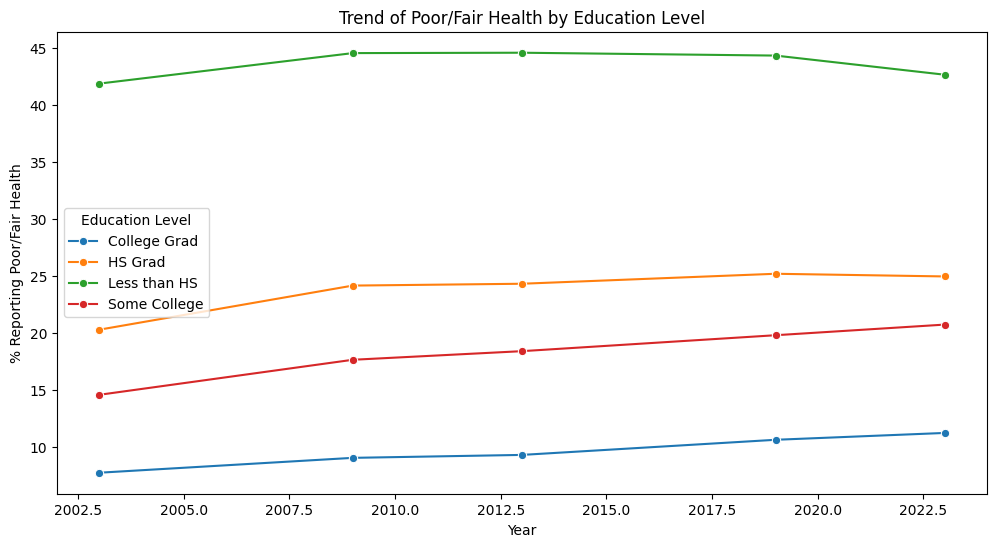

<Figure size 640x480 with 0 Axes>

In [7]:
# Map education
edu_map = {1: 'Less than HS', 2: 'HS Grad', 3: 'Some College', 4: 'College Grad'}
if '_EDUCAG' in df_all.columns:
    df_all['Education Level'] = df_all['_EDUCAG'].map(edu_map)

# Define poor/fair (assuming 2=Fair, 3=Poor)
df_all['PoorFair'] = df_all['_RFHLTH'].isin([2,3]).astype(int)

# Filter valid data
df_health = df_all[['Year', 'Education Level', 'PoorFair']].dropna()

# Group → calculate % poor/fair
health_trend = df_health.groupby(['Year', 'Education Level'])['PoorFair'].mean().reset_index()
health_trend['Percent'] = 100 * health_trend['PoorFair']

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=health_trend, x='Year', y='Percent', hue='Education Level', marker='o')
plt.title('Trend of Poor/Fair Health by Education Level')
plt.ylabel('% Reporting Poor/Fair Health')
plt.show()

# Optional export
plt.savefig('/content/health_trend.png')
